# <font color ="FFA500">Forecasting Inflation rates with SARIMA </font>


**SARIMA** is an extension of the regular ARIMA model that adds a seasonality component to the model. This allows us to better capture seasonal affects that the regular ARIMA model does not permit.
To produce SARIMA(p, d, q)(P, D, Q)m,  a seasonality component is added to each factor of the classic ARIMA equation

$$
y_t' = c + \sum_{n=1}^{p} \phi_n y_{t-n}' + \sum_{n=1}^{q} \theta_n \varepsilon_{t-n}
+ \sum_{n=1}^{P} \eta_n y_{t-mn}' + \sum_{n=1}^{Q} \omega_n \varepsilon_{t-mn} + \varepsilon_t
$$
 Where:

y’: differenced time series, through both regular, d, and seasonal, D, differencing
P: number of seasonal auto-regressors
ω: coefficients of the seasonal autoregressive components
Q: number of seasonal moving-average components
η: coefficients of the seasonal forecast errors
m: length of season


### Limitation of SARIMA

One key limitation of the **SARIMA** model is that it **cannot handle multiple seasonalities**.  
It is designed to capture only a **single seasonal pattern** (e.g., monthly or weekly), making it unsuitable for datasets that exhibit **more than one seasonal cycle** (e.g., both daily and yearly patterns).






## <font color ="FFA500">Key Considerations</font>

### 1. Stationarity Requirement

SARIMA models require the time series to be **stationary**, meaning:
- No long-term trend or persistent seasonality
- Constant mean and variance over time

To achieve stationarity:
- **Mean stabilization** is done through differencing:
  - Regular differencing → order \( d \)
  - Seasonal differencing → order \( D \)
- **Variance stabilization** can be achieved using:
  - Log transformation
  - Box-Cox transformation  
These help normalize the amplitude of seasonal fluctuations across time.

---

### 2. Order Selection

Once the series is stationary, we determine the model orders:

#### a. Differencing Orders
- \( d \): Number of regular differences  
- \( D \): Number of seasonal differences  
Use the **Augmented Dickey-Fuller (ADF)** test to assess whether differencing is required.

#### b. AR and MA Orders  
- Regular terms: \( p \) (AR), \( q \) (MA)  
- Seasonal terms: \( P \) (SAR), \( Q \) (SMA)  
Analyze:
- **Partial Autocorrelation Function (PACF)** → identifies AR (p, P)  
- **Autocorrelation Function (ACF)** → identifies MA (q, Q)  



---



# `Data Loading and Visualization`

In [ ]:
!pip install pmdarima
!pip install pymannkendall

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pymannkendall as mk
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

In [ ]:
infl_df = pd.read_csv('/content/monthly_inflation_rates')

In [ ]:
infl_df

,Unnamed: 0,Date,Monthly_CPI,Monthly_Inflation,Monthly_Rate
0,0,1960-01-01,1.678984,NaN,NaN
1,1,1960-02-01,1.678984,1.000000,0.000000
2,2,1960-03-01,1.664416,0.991323,-0.867679
3,3,1960-04-01,1.678984,1.008753,0.875274
4,4,1960-05-01,1.689910,1.006508,0.650759
...,...,...,...,...,...
716,716,2019-09-01,123.175008,1.006250,0.625000
717,717,2019-10-01,124.322601,1.009317,0.931677
718,718,2019-11-01,125.470194,1.009231,0.923077
719,719,2019-12-01,126.235257,1.006098,0.609756


In [ ]:

infl_df["Date"]= pd.to_datetime(infl_df["Date"])




In [ ]:
infl_df=infl_df.set_index("Date")
infl_df

,Unnamed: 0,Monthly_CPI,Monthly_Inflation,Monthly_Rate,Bank Rate
Date,,,,,
1960-01-01,0,1.678984,NaN,NaN,4.00
1960-02-01,1,1.678984,1.000000,0.000000,4.00
1960-03-01,2,1.664416,0.991323,-0.867679,4.00
1960-04-01,3,1.678984,1.008753,0.875274,4.00
1960-05-01,4,1.689910,1.006508,0.650759,4.00
...,...,...,...,...,...
2019-09-01,716,123.175008,1.006250,0.625000,5.65
2019-10-01,717,124.322601,1.009317,0.931677,5.65
2019-11-01,718,125.470194,1.009231,0.923077,5.65


In [ ]:

infl_df = infl_df.drop(columns="Unnamed: 0")

In [ ]:
infl_df.columns

Index(['Unnamed: 0', 'Date', 'Monthly_CPI', 'Monthly_Inflation',
       'Monthly_Rate'],
      dtype='object')

In [ ]:
infl_df.isnull().sum()

,0
Unnamed: 0,0
Date,0
Monthly_CPI,0
Monthly_Inflation,2
Monthly_Rate,2


In [ ]:
infl_df.dropna(inplace= True)

In [ ]:
infl_df.index.duplicated().sum()  # check for duplicate timestamps

0

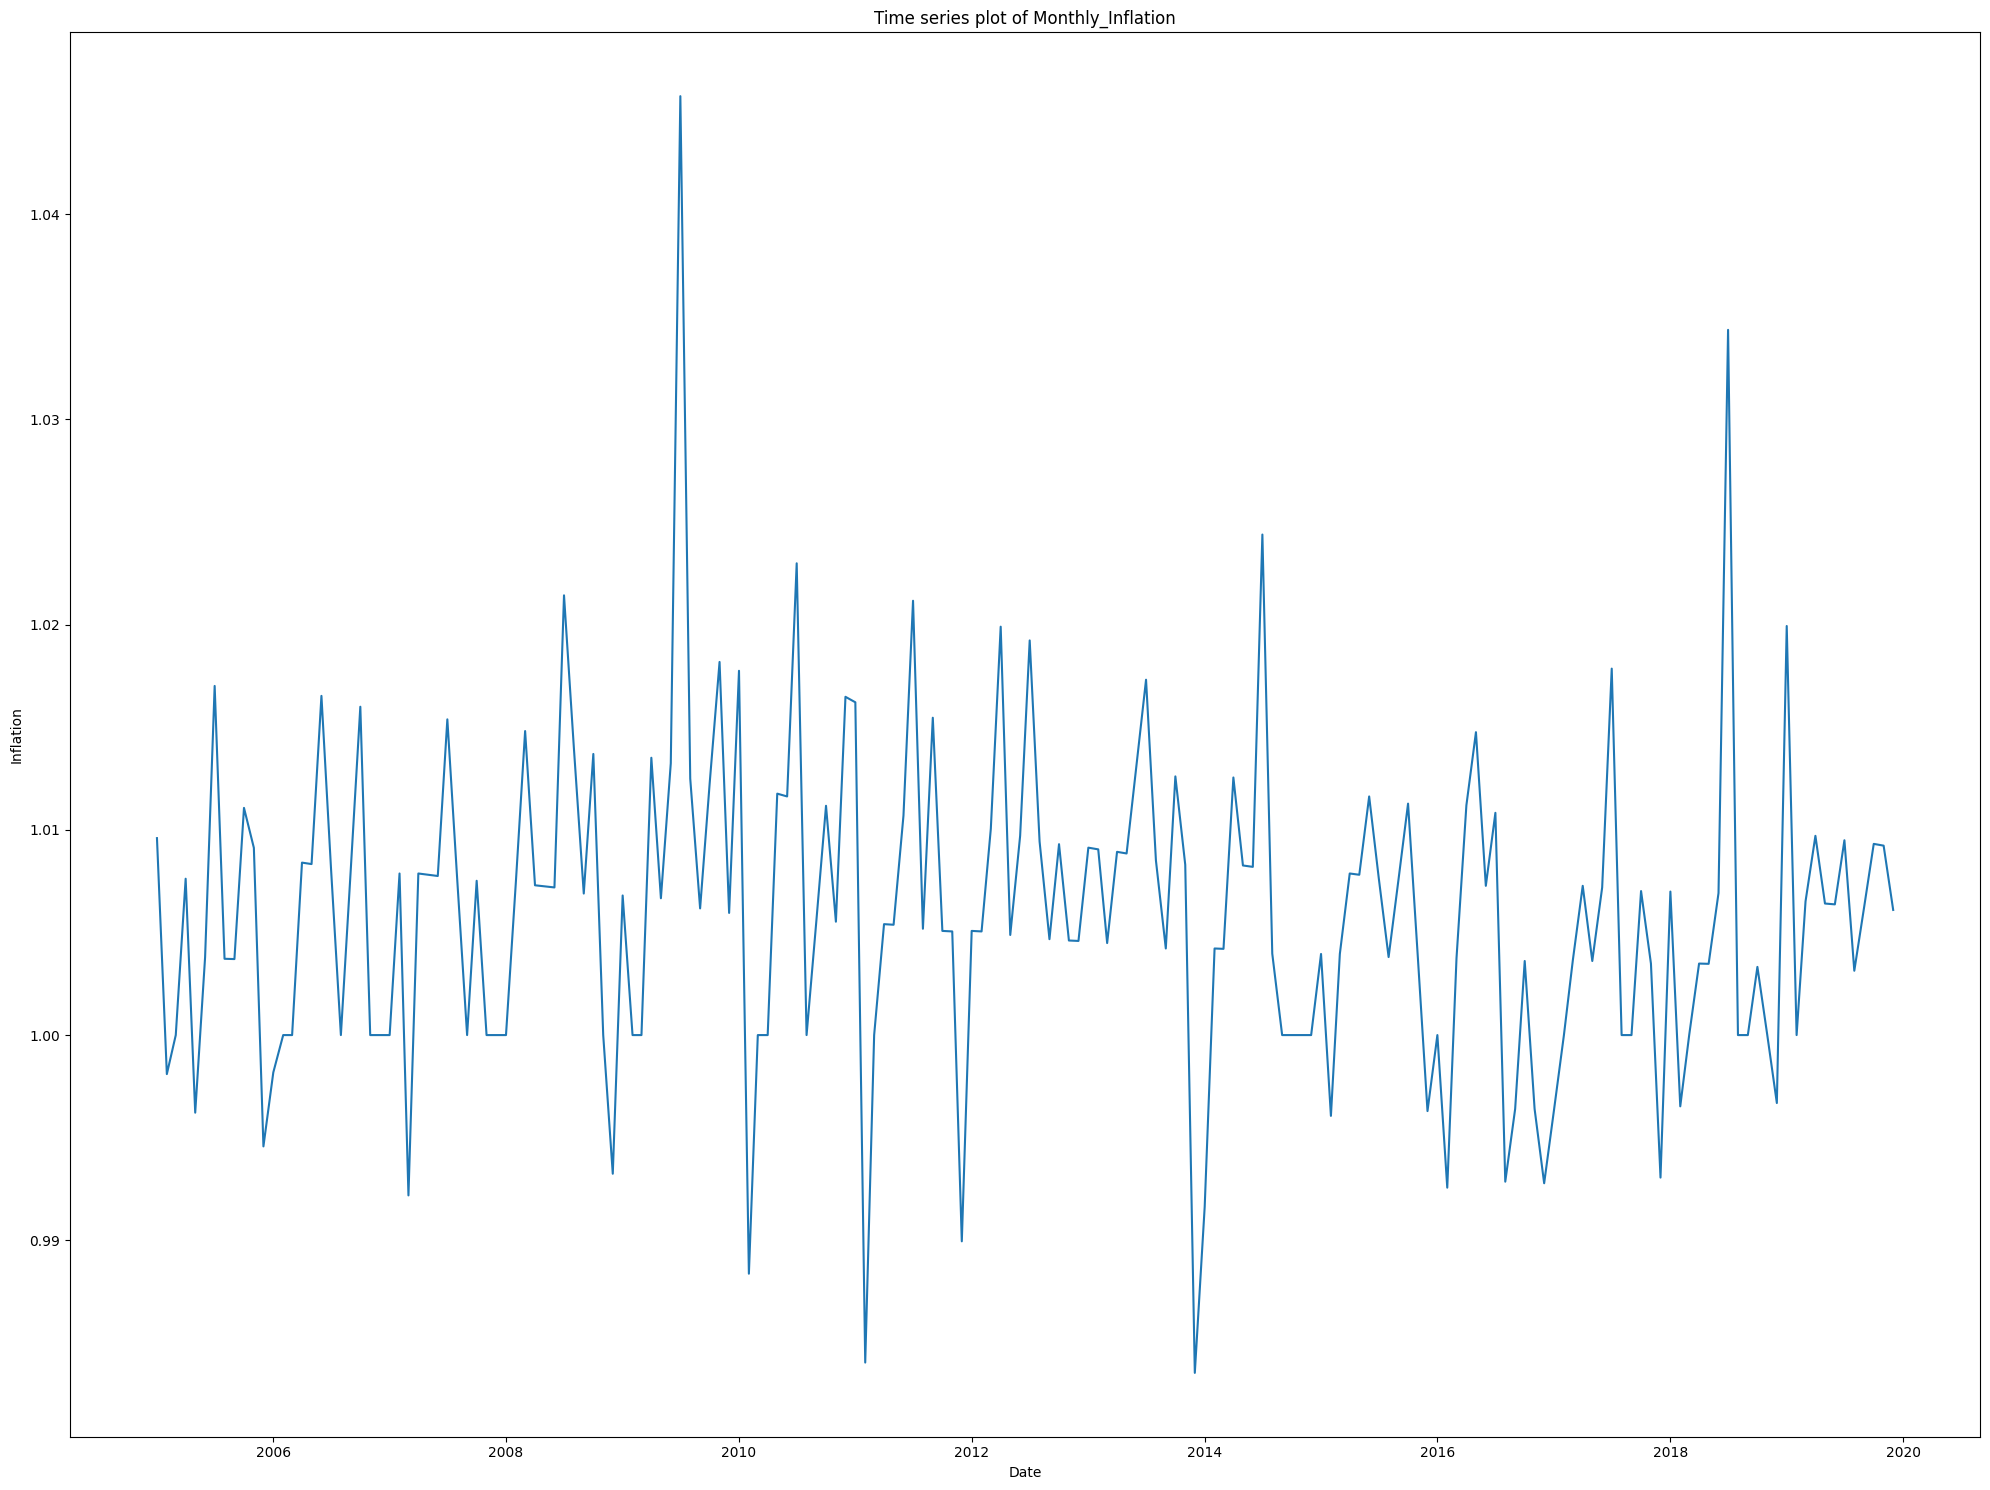

In [ ]:


plt.figure(figsize=(20, 15))
plt.plot(infl_df.loc["2005-01-01":].index, infl_df['Monthly_Inflation'].loc["2005-01-01":], label="Inflation")


plt.title("Time series plot of Monthly_Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.tight_layout()
plt.show()

# `Seasonal Decomposition`

This technique allows us to identify three main components of time series:

1. **Trend** – the long-term progression or direction of the data.
2. **Seasonality** – repeating patterns or cycles at regular intervals (e.g., yearly, monthly).
3. **Residual** – random noise or irregular fluctuations after removing trend and seasonality.


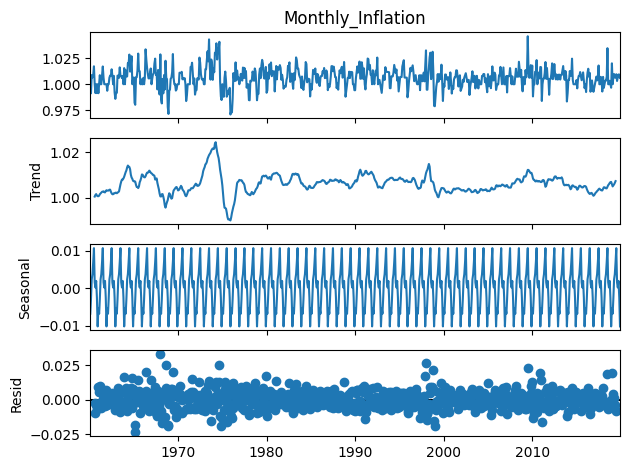

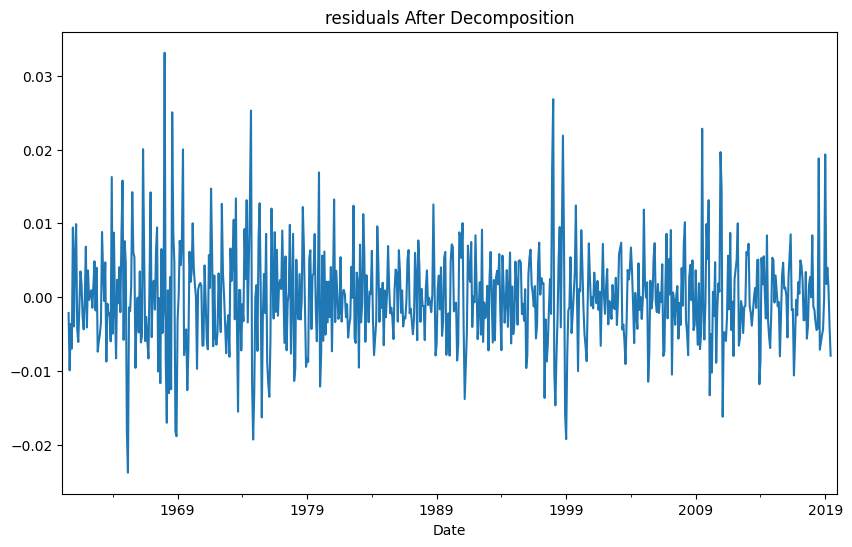

In [ ]:

df =infl_df.dropna()
# Decompose the time series data
result = seasonal_decompose(infl_df["Monthly_Inflation"], model='additive', period=12)# additive model in this case will give A good residual plot = random noise → model fits well.
# Plot decomposition
result.plot()

plt.show()
# Plot residuals
residual = result.resid
residual.plot(figsize=(10, 6))
plt.title("residuals After Decomposition")
plt.show()




**OBSERVATION**:
- There is no visible downward or upward trend however the  seasonality is very evident. THis suggests the time series is non stationary


# `Analyzing ACF Plots for Seasonality check`
- The autocorrelation graph displays the correlation between the observations at the current point in time and the observations at all previous points in time. Repearing spikes in autocorrelation graphs gives us an idea about presence of seasonlity


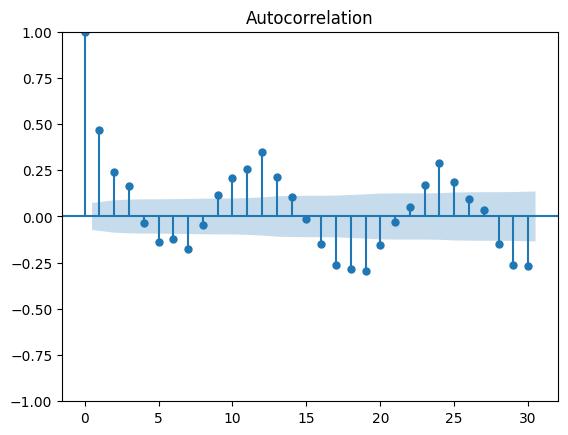

In [ ]:
# subtracting the current value from the previous value

plot_acf(infl_df["Monthly_Inflation"], lags=30)
plt.show()
plt.show()


**OBSERVATION**:
- In the  plot we observe significant spikes for most of the lags  and a clear repeating pattern  which indicates presence of seasonality


## Monthly Inflation Pattern Analysis Using `month_plot()`

The `month_plot()`  creates a seasonal subseries plot for time series with monthly frequency.

### What it does:
- Requires a time series with monthly frequency. If your data is daily or weekly, it should be resampled to monthly.
- Plots each year's monthly values as separate lines.
- Overlays a red line showing the average value for each calendar month across all years.

### Why it is useful:
- Helps visualize whether seasonal patterns are consistent across years.
- Highlights typical behavior for each month based on historical averages.
- Makes it easy to spot years that deviate from the average seasonal pattern.


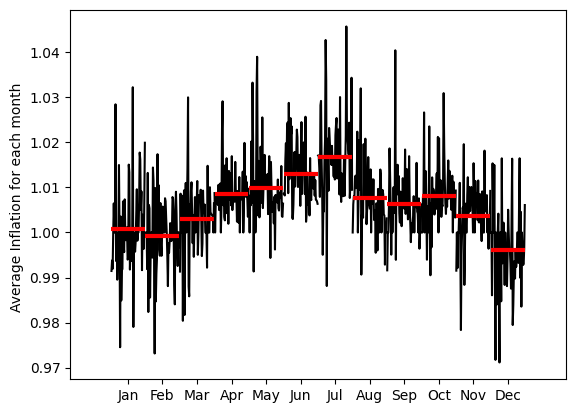

In [ ]:
month_plot(infl_df["Monthly_Inflation"],ylabel = 'Average Inflation for each month ')
plt.show()

## Quarterly Inflation Pattern Analysis Using `quarter_plot()`

The `quarter_plot()` functioncreates a seasonal subseries plot for time series with quarterly frequency.

### What it does:
- Requires a time series with quarterly frequency (`DatetimeIndex` or `PeriodIndex`).
- Plots each year's quarterly values (Q1–Q4) as separate lines.
- Overlays a red line showing the average value for each calendar quarter across all years.

### Why it is useful:
- Reveals whether certain quarters consistently show higher or lower values.
- Allows comparison of quarterly trends across different years.
- Highlights deviations from typical seasonal patterns.

/tmp/ipython-input-16-3515974459.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(infl_df["Monthly_Inflation"].resample('Q').mean(), ylabel = 'Average Quaterly inflation of all months')


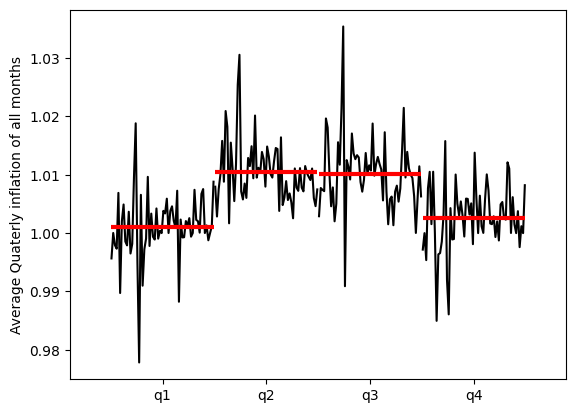

In [ ]:
quarter_plot(infl_df["Monthly_Inflation"].resample('Q').mean(), ylabel = 'Average Quaterly inflation of all months')
plt.show()

# `Individual check on Trend and  Seasonlaity using Mankendall and Freidmanchisquare test`


In [ ]:
col="Monthly_Inflation"

In [ ]:

# Perform Mann-Kendall test

result = mk.original_test(infl_df[col].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.602270082239404, z=-0.5211388020751264, Tau=-0.012978409350653376, s=-3350.0, var_s=41297472.666666664, slope=0.0, intercept=1.006125574268749)


In [ ]:
from scipy.stats import friedmanchisquare
def seasonality_check(df,col):
    # Drop NaNs (e.g., from differencing)
    values = df[col].dropna().values

    # Ensure the length is divisible by 12 (e.g., complete years)
    length = len(values) - (len(values) % 12)
    values = values[:length]

    # Reshape to (n_years, 12 months)
    data = values.reshape(-1, 12)

    # Apply Friedman test across columns (months)
    stat, p = friedmanchisquare(*data.T)
    print(f"Friedman p-value: {p:.6f}")

    # If p-value < 0.05, reject the null hypothesis of equal distributions across months
    if p < 0.05:
        print("There are significant differences in the distributions of electric production across months, Means Seasonality exists.")
    else:
        print("No significant differences in the distributions of electric production across months, Seasonality does not exist.")

seasonality_check(infl_df,"Monthly_Inflation")

Friedman p-value: 0.000000
There are significant differences in the distributions of electric production across months, Means Seasonality exists.


- **Results**
- No Trend
- Presence of Strong Seasonality
- The data is non stationary



# `Seasonal Differencing to achieve Stationary`

In [ ]:
seasonal_adjusted_df = infl_df.copy()
seasonal_adjusted_df['seasonal_adjusted_inflation_rate'] = seasonal_adjusted_df['Monthly_Inflation'] - seasonal_adjusted_df['Monthly_Inflation'].shift(12)
#inf_df2=infl_df.dropna()

In [ ]:
col="seasonal_adjusted_inflation_rate"

In [ ]:
seasonality_check(seasonal_adjusted_df,"seasonal_adjusted_inflation_rate")

Friedman p-value: 0.997857
No significant differences in the distributions of electric production across months, Seasonality does not exist.


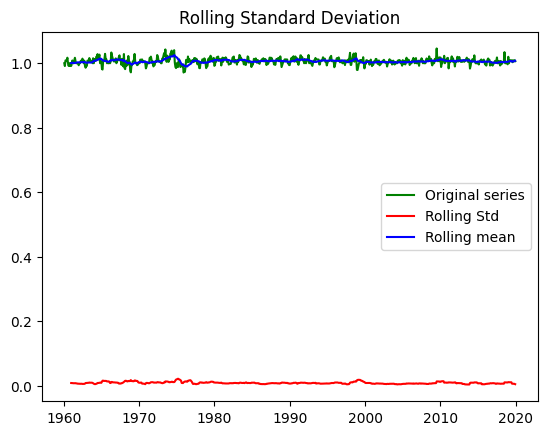

In [ ]:
def plot_roll_mean_std(df,col):

    rolling_std =df[col].rolling(window=12).std()
    rolling_mean =df[col].rolling(window=12).mean()
    plt.plot(df[col], label ="Original series",color="green")
    plt.plot(rolling_std, label='Rolling Std', color='red')
    plt.plot(rolling_mean,label="Rolling mean", color ="blue")
    plt.legend()
    plt.title("Rolling Standard Deviation")
    plt.show()
plot_roll_mean_std(seasonal_adjusted_df,"Monthly_Inflation")


# `Determining order of SARIMA using ACF/PACF Plots on Seasonally adjusted data`
- The autocorrelation graph displays the correlation between the observations at the current point in time and the observations at all previous points in time. Spike in autocorrelation graphs tells us the number of Auto-Regressive (AR) terms or the number of lags.
- The partial autocorrelation graph displays the duration of the influence of a random shock, i.e. correlation which is not explained by the set of explanatory variables. Spike in the partial autocorrelation tells us the number of Moving Average (MR) Terms.

---
- On the  y_axis we have the pearson correatation values between -1 and 1 , 1 = perfect posiitve correatlion, -1 = perfect negative correlation and 0 = no correaltion.
- The shaded region in both the graphs represents a 95% confidence interval band.
- Anything outside the shaded region signifies a statistically significant correlation.
- Anything within the shaded region signifies no significant correltion

In [ ]:
seasonal_adjusted_df.dropna(inplace = True)

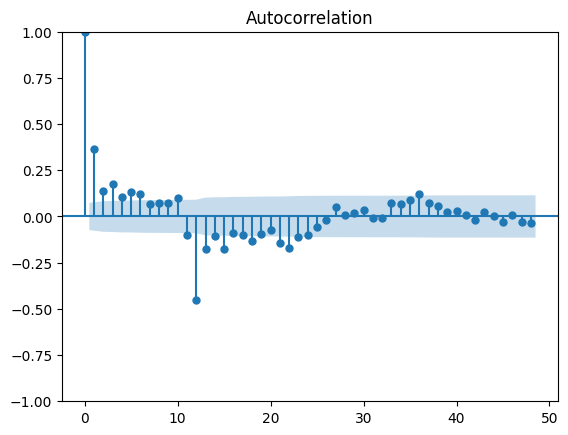

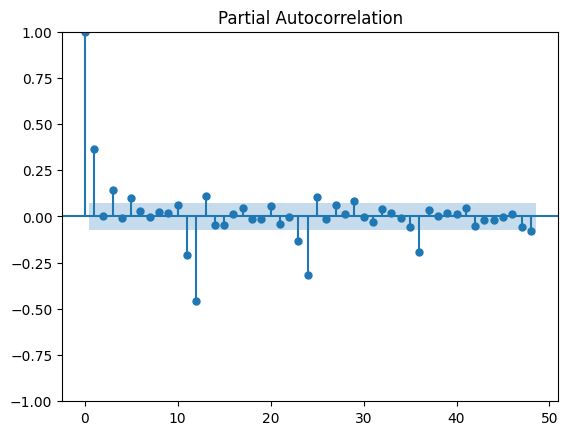

In [ ]:
# subtracting the current value from the previous value
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(seasonal_adjusted_df[col], lags=48)
plt.show()

plot_pacf(seasonal_adjusted_df[col], lags=48)
plt.show()

### **Observations**

#### 🔹 *Non-Seasonal tems - AR(p), MA(q)*  
- **ACF for MA** shows significant autocorrelations fom **lags 1 and  3** so we choose either 1,3 or 5 for q,
- **PACF for AR** shows prominent spikes at **lags 1 and 3**

#### 🔹 *Seasonal terms - AR(P) MA(Q) determined as  (Multiples of 12)*  
- **ACF for MA** shows a clear **negative spike at lag 12**, so we select the lag 1 ( multiple of 12) for seasonal Q.  
- **PACF** shows significant spikes at **lags 12, and 24**, so we select the lag 1 or lag 2 (multiples of 12) for seasonal P.

---

### **Model Parameters to Consider**

#### 🔹 *Non-Seasonal Terms*  : we will not consider lag 3 to avoid overfitting
- **AR terms (p):** {0,1}  
- **MA terms (q):** {0,1}


#### 🔹 *Non Seasonal Terms*  
- **AR terms (P):** {0,1, 2}  
- **MA terms (Q):** {0,1}



**NOTE**; The d/D value will be 0 since the data is already stationary in mean i.e it showed no trend  and we did not need to differnce it .


# `Train/Test Split`

In [ ]:
len(infl_df["Monthly_Inflation"])

719

In [ ]:
infl_df.asfreq('ME')
train = infl_df["Monthly_Inflation"][:-36]
test = infl_df["Monthly_Inflation"][-36:]

In [ ]:
test.head()

,Monthly_Inflation
Date,
2017-01-01,0.996364
2017-02-01,1.000000
2017-03-01,1.003650
2017-04-01,1.007273
2017-05-01,1.003610


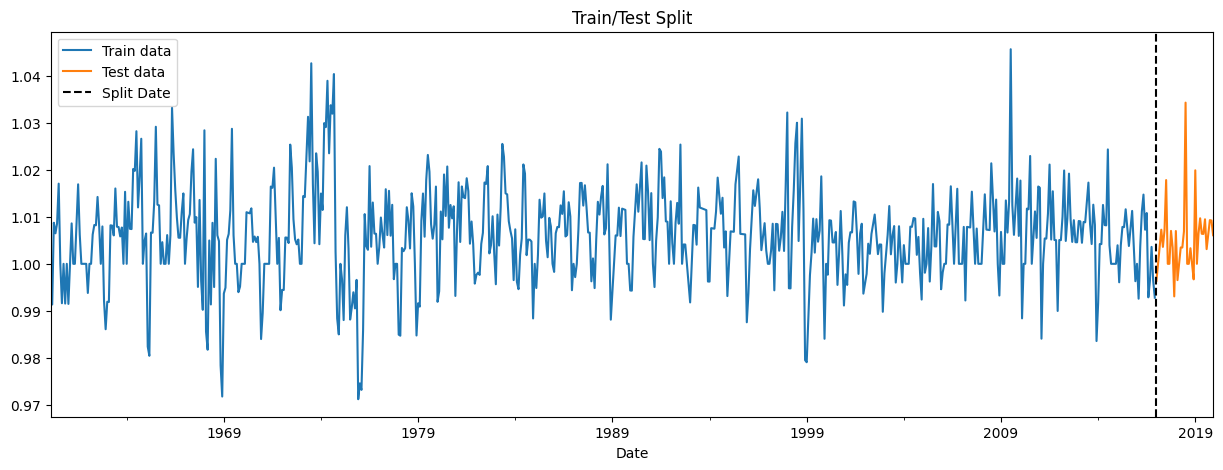

In [ ]:


fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label="Train data")
test.plot(ax=ax, label="Test data")

ax.axvline("2017-01-01", color="black", linestyle="--", label="Split Date")  #
ax.legend()
plt.title("Train/Test Split")
plt.show()


# `Modeling with Sarima`

## Using Auto ARIMA to Detect the Best Order by AIC

`Auto_arima` is commonly used to automatically determine the best (p, d, q) and (P, D, Q, s) order for ARIMA/SARIMA models. IT aims to select a model that fits the data well **without being overly complex**
By default, it selects the model with the **lowest AIC (Akaike Information Criterion)**, but this can be changed to BIC.

---

### Model Selection Criteria

-- **AIC (Akaike Information Criterion):**  
  Evaluates model quality by balancing fit and complexity.  
##### AIC Formula

$$
\text{AIC} = -2 \cdot \ln(\text{Likelihood}) + 2k
$$
Where:  
- $ \ln(\text{Likelihood}) $: Measures how well the model fits the data  
- $ k $: Number of model parameters
---

### 🔹 What This Means:
- The **first term** rewards better model fit (higher likelihood → lower AIC).
- The **second term** penalizes model complexity (more parameters increase AIC).
- So: **More parameters → higher AIC**, unless they substantially improve the fit.

→ **Lower AIC** indicates a better trade-off between goodness of fit and model simplicity.

- **BIC (Bayesian Information Criterion):**  
  Similar to AIC but applies a **stronger penalty** for model complexity.  
  → Often results in **simpler models**, reducing the risk of overfitting.

---

**BIC (Bayesian Information Criterion):**  
  Measures model quality with a stronger penalty for complexity compared to AIC.  
  It is especially useful when aiming for simpler, more generalizable models.

##### BIC Formula

$$
\text{BIC} = -2 \cdot \ln(\text{Likelihood}) + k \cdot \ln(n)
$$

Where:  
- $ \ln(\text{Likelihood}) $: Measures how well the model fits the data  
- $ k $: Number of model parameters  
- $ n $: Number of observations (sample size)
---

### 🔹 What This Means:
- The **first term** rewards better model fit (higher likelihood → lower BIC).  
- The **second term** penalizes model complexity more heavily than AIC, especially as sample size \( n \) increases.  
- So: **More parameters → much higher BIC**, unless they greatly improve the fit.

→ **Lower BIC** indicates a simpler, more parsimonious model that still fits the data well.


In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")




stepwise_model = auto_arima(train,
                             seasonal=True, m=12,
                             trace=True,
                             information_criterion='aic',
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(f"\nBest SARIMA model order: {stepwise_model.order} Seasonal Order: {stepwise_model.seasonal_order}")





Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-4612.438, Time=13.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-4369.609, Time=0.40 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=12.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-4562.836, Time=3.83 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1948.676, Time=0.08 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-4561.463, Time=3.51 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=71797.831, Time=0.61 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-4590.071, Time=5.00 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-4529.133, Time=0.31 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=8.12 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-4588.631, Time=4.07 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept 

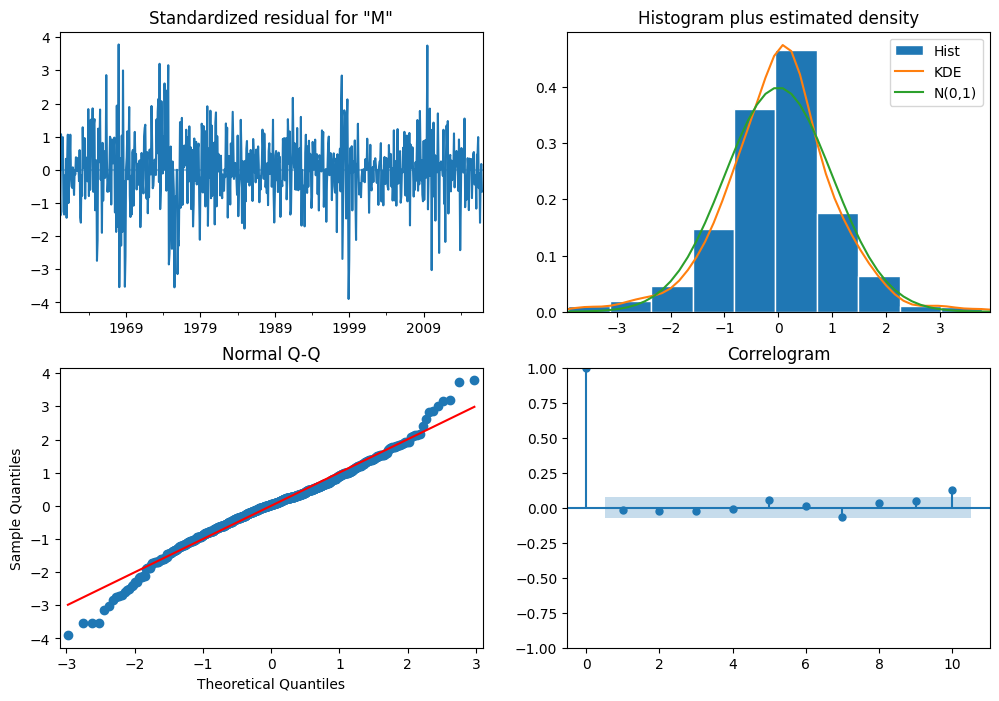

In [ ]:



model1 = SARIMAX(train,
                order=stepwise_model.order,
                seasonal_order=stepwise_model.seasonal_order,

                 trend='c',
               ).fit(disp=True)



model1.plot_diagnostics(figsize=(12, 8))
plt.show()

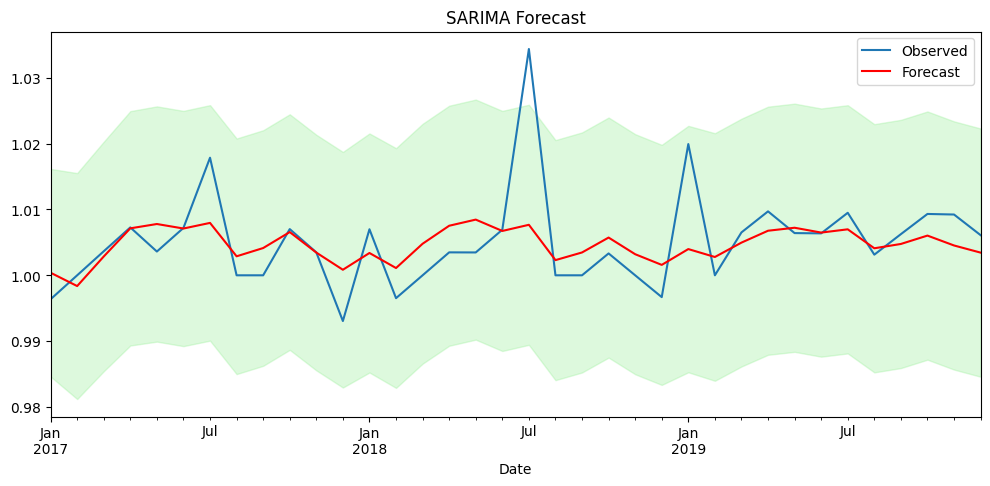

Mean Value of Test Dataset: 1.0051038366820229
RMSE : 0.01
 MAPE  0.39 %


In [ ]:
def plot_forecasts(model,exog=None):
    n_forecast = len(test)


    forecast = model.get_forecast(steps=n_forecast,exog=exog)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Plot the forecast
    ax = test.plot(label='Observed', figsize=(12, 5))
    forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red')
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
    plt.legend()
    plt.title("SARIMA Forecast")
    plt.show()

    import numpy as np




    mape = mean_absolute_percentage_error(test, forecast_mean)
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))

    # Print results clearly
    print("Mean Value of Test Dataset:", test.mean())

    print(f"RMSE : {rmse:.2f}")
    print(f" MAPE  {100 * mape:.2f} %")


    return forecast_mean
forecast1=plot_forecasts(model1)


# `Modeling with Manually detected orders with ACF and PACF`

### **Model Parameters to Consider**

#### 🔹 *Non-Seasonal Terms*  
- **(p):** 1  
- **(q):** 0


#### 🔹 *Seasonal Terms*  
- **(P):** 2  
- **(Q):** 1


In [ ]:



model2 = SARIMAX(train,
                order=(1,0,0),
                seasonal_order=(2,0,1,12),

                 trend='c',
               ).fit(disp=True)


#model2.plot_diagnostics(figsize=(12, 8))
#plt.show()

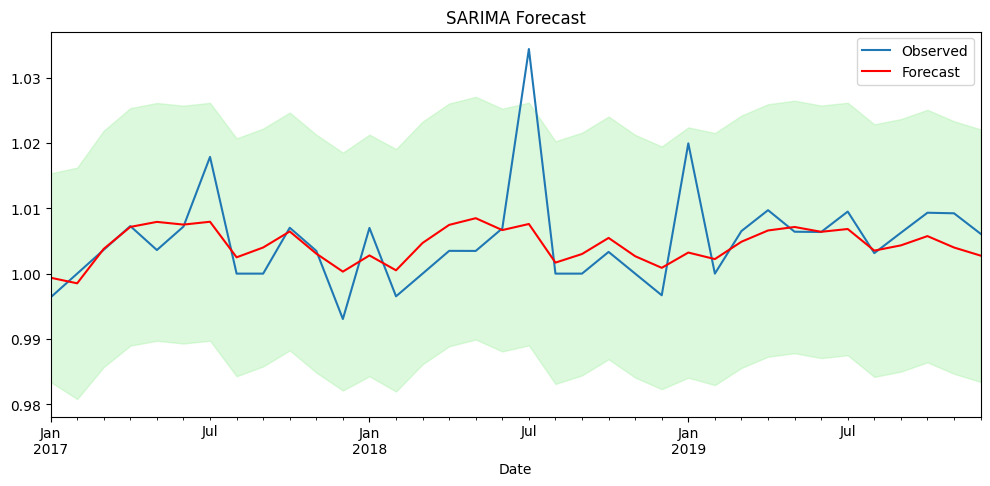

Mean Value of Test Dataset: 1.0051038366820229
RMSE : 0.01
 MAPE  0.38 %


In [ ]:


forecast2=plot_forecasts(model2)


# Comparison of Manual vs. Auto ARIMA Parameter Estimation
- Both the manually estimated ARIMA model and the auto ARIMA model demonstrate comparable performance, as indicated by their similar MAPE (Mean Absolute Percentage Error) values.



# Modeling SARIMA with Exogenous variables

In [ ]:
# we create the lagges features of monthly cpi and montly rate since inclduing them as it is will lead to data leakage

infl_df['Monthly_CPI_lag1'] = infl_df['Monthly_CPI'].shift(1)
infl_df['Monthly_Rate_lag1'] = infl_df['Monthly_Rate'].shift(1)


In [ ]:
infl_df.dropna(inplace=True)

In [ ]:

train = infl_df["Monthly_Inflation"][:-36]
test = infl_df["Monthly_Inflation"][-36:]
exog_cols = ['Monthly_CPI_lag1', 'Monthly_Rate_lag1']

exog_train = infl_df.iloc[:-36].loc[:, exog_cols]
exog_test = infl_df.iloc[-36:].loc[:, exog_cols]



In [ ]:
sarimax = auto_arima(train,m = 12,stepwise=True,information_criterion='aic', exogenous=exog_train ,seasonal=True,
                             suppress_warnings=True,
                             )

print(f"\nBest SARIMAX  order: {sarimax.order} Seasonal Order: {sarimax.seasonal_order}")



Best SARIMAX  order: (2, 0, 3) Seasonal Order: (2, 0, 1, 12)


In [ ]:
model3 = SARIMAX(endog=train,
    exog=exog_train,
                order=sarimax.order,
                seasonal_order=sarimax.seasonal_order,

                 trend='c',
               ).fit(disp=True)



#model3.plot_diagnostics(figsize=(12, 8))
#plt.show()

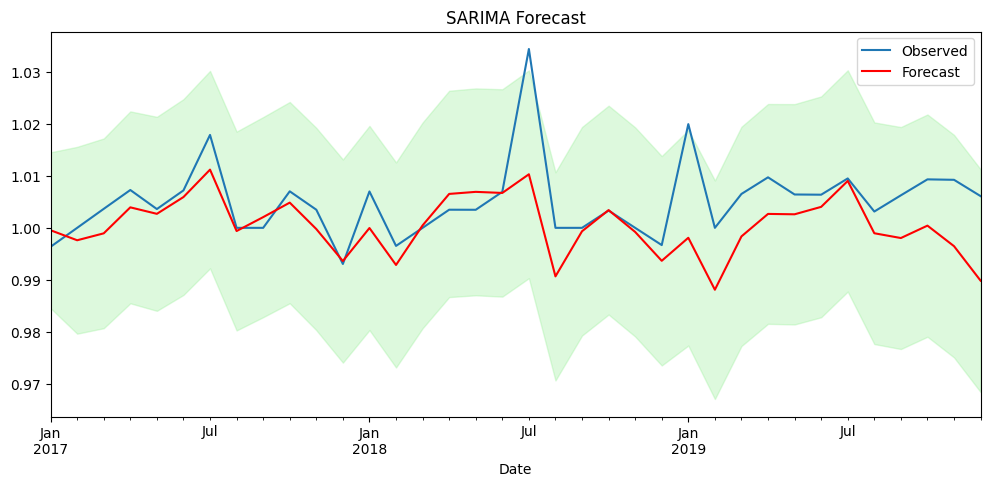

Mean Value of Test Dataset: 1.0051038366820229
RMSE : 0.01
 MAPE  0.53 %


In [ ]:
forecast3=plot_forecasts(model3,exog=exog_test)

---

#Key Observavtions
#### 🔹SARIMAX (without exog variables)

* **Exogenous Variables Used**: *None (pure SARIMA model)*
* **MAPE**: `0.38`
* **Observations**:
  * Captures mean better — forecast stays close to the long-term average.
  * Smoother and more stable predictions — likely more robust for generalization.
  * Underrepresents variance — fails to reflect the true ups and downs.

Doesn’t follow sharp changes well — misses short-term patterns in the data.



**Conclusion**: This model performs better overall. It balances accuracy (lower MAPE) and the ability to capture trends and turning points. However it could not clearly capture the variance

---

#### 🔹 SARIMAX(with exog variables)

* **Exogenous Variables Used**: *Lagged values of Monthly CPI and Monthly Rate*
* **MAPE**: `0.53`
* **Observations**:
  * Captures variance better — reflects fluctuations in the data.
  * Follows the observed curve more closely — tracks peaks and troughs well.
  * Less stable mean estimate — forecast line fluctuates around the true mean.

 **Conclusion**: Despite including theoretically relevant lagged economic indicators, the model **underperforms** in terms of estimating mean compared to the baseline SARIMA.  and also  the increase in MAPE reflects reduced forecast accuracy.

---

